In [447]:
# Standard 
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import time
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Neural network
import torch
import torch.nn as nn
from torch import optim

# Functions

In [448]:
def CreateTensorDataset(features, labels):
    dataset = TensorDataset(
        torch.from_numpy(features).float(),
        torch.from_numpy(labels).float()
    )

    return dataset

def CreateDataLoaders(tensor_data, batchsize, shuffle):
    dl = DataLoader(
        tensor_data, 
        batch_size=batchsize,
        shuffle=shuffle
    )

    return dl

# Import clean data

In [449]:
# Time start
start = time.time()

# Load csv-file and display 5 first rows
clean = pd.read_csv("clean.csv", sep = ",", index_col="Unnamed: 0")
clean.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


# Split and scale data

In [450]:
# Features and labels
X = clean.drop("Outcome", axis = 1)
features = X.columns.to_list()
y = clean["Outcome"].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y, test_size=0.2)

# Scaler
scaler = StandardScaler()

# Transform features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create TensorDatasets

In [451]:
# Train tensor dataset
tensor_train = CreateTensorDataset(X_train_scaled, y_train)

# Test tensor dataset
tensor_test = CreateTensorDataset(X_test_scaled, y_test)

# Create DataLoaders

In [452]:
# Train DataLoader
train_dataloader = CreateDataLoaders(tensor_train, 16, True)

# Test DataLoader
test_dataloader = CreateDataLoaders(tensor_test, 16, True)

# Neural Network

In [453]:
class Net(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.extract = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ELU(),
            nn.Linear(128, 1024),

            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout1d(p = 0.1),

            nn.Linear(1024, 8192),
            nn.ELU(),
            nn.Linear(8192, 1024),

            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout1d(p = 0.01),

            nn.Linear(1024, 128),
            nn.ELU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = self.extract(x)
        x = self.classifier(x)
        return x

# Model, optimizer, loss function and scheduler

In [454]:
# Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = Net(n_features=len(features)).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.000001, weight_decay=10e-4)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience=3, factor=0.33)

# Training and testing

In [455]:
# Early stop
counter = 0
patience = 10
best_loss = np.inf

# Losses
train_losses = []
test_losses = []

for epoch in range(1000):
    start_epoch = time.time()
    model.train()
    train_total_loss = 0
    for features, target in train_dataloader:
            target = target.float().unsqueeze(1)
            optimizer.zero_grad()
            pred = model(features)
            loss = criterion(pred, target)
            train_total_loss += loss.item()
            loss.backward()
            optimizer.step()

    # Loss
    train_loss = train_total_loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    # True and predicted targets
    true_target = []
    pred_target = []

    model.eval()
    with torch.no_grad():
        test_total_loss = 0
        for features, target in test_dataloader:
            target = target.float().unsqueeze(1)
            pred = model(features)

            # Calculate probability
            prob = torch.sigmoid(pred)

            # True and predicted target
            true_target.extend(target)
            pred_target.extend(prob)

            loss = criterion(pred, target)
            test_total_loss += loss.item()
    
    # Loss
    test_loss = test_total_loss/len(test_dataloader)
    test_losses.append(test_loss)

    # Save best model and counter for early stop
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0

        # Gem model
        torch.save(model.state_dict(), "best_model")
    else:
        counter += 1
    
    # Early stop
    if counter > patience:
        print(f'Best model saved!')
        break

    # Schduler
    scheduler.step(test_loss)

    # Epoch end time
    end_epoch = time.time()

    print(f'Epoch: {epoch + 1}\nEpoch time: {end_epoch-start_epoch:.2f}s\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}\nBest test loss: {best_loss:.4f} | Early break: {counter}/{patience}\n')

Epoch: 1
Epoch time: 1.05s
Train loss: 0.6955 | Test loss: 0.6768
Best test loss: 0.6768 | Early break: 0/10

Epoch: 2
Epoch time: 1.00s
Train loss: 0.6330 | Test loss: 0.6148
Best test loss: 0.6148 | Early break: 0/10

Epoch: 3
Epoch time: 0.95s
Train loss: 0.5866 | Test loss: 0.5800
Best test loss: 0.5800 | Early break: 0/10

Epoch: 4
Epoch time: 0.93s
Train loss: 0.5738 | Test loss: 0.5665
Best test loss: 0.5665 | Early break: 0/10

Epoch: 5
Epoch time: 0.94s
Train loss: 0.5622 | Test loss: 0.5250
Best test loss: 0.5250 | Early break: 0/10

Epoch: 6
Epoch time: 0.89s
Train loss: 0.5291 | Test loss: 0.5375
Best test loss: 0.5250 | Early break: 1/10

Epoch: 7
Epoch time: 0.94s
Train loss: 0.5122 | Test loss: 0.5239
Best test loss: 0.5239 | Early break: 0/10

Epoch: 8
Epoch time: 0.93s
Train loss: 0.5186 | Test loss: 0.5117
Best test loss: 0.5117 | Early break: 0/10

Epoch: 9
Epoch time: 0.96s
Train loss: 0.4887 | Test loss: 0.5059
Best test loss: 0.5059 | Early break: 0/10

Epoch: 10


# Visualize loss

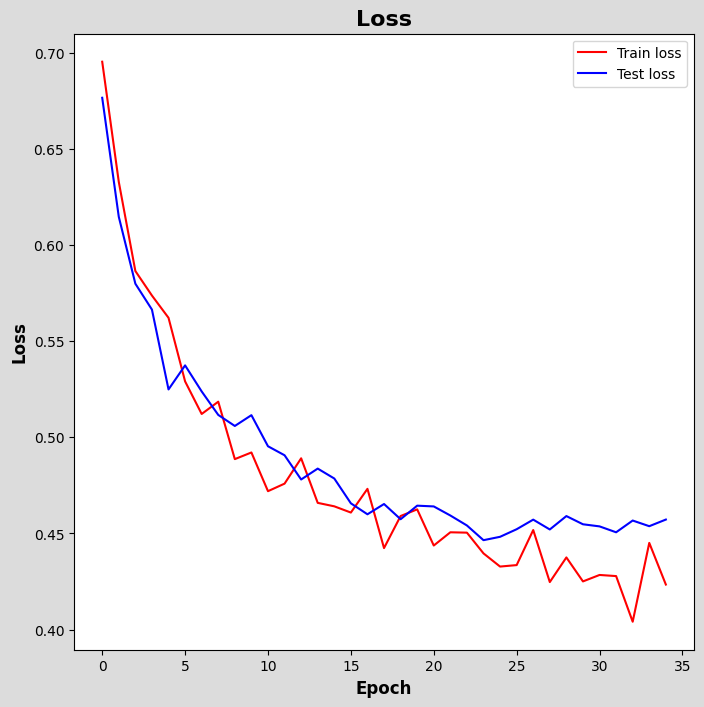

In [456]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_facecolor("#ffffff")
fig.set_facecolor("#DCDCDC")
plt.plot(
    train_losses,
    color = "red",
    label = "Train loss"
)
plt.plot(
    test_losses,
    color = "blue",
    label = "Test loss"
)
plt.title(
    "Loss",
    fontsize = 16,
    fontweight = "bold"
    )
plt.xlabel(
    "Epoch",
    fontsize = 12,
    fontweight = "bold"
    )
plt.ylabel(
    "Loss",
    fontsize = 12,
    fontweight = "bold"
    )
plt.legend()
plt.show()


# Prepare predictions for confusion matrix

In [457]:
pred_binary = []
for i in pred_target:
    if i < 0.5:
        pred_binary.append(0)
    else:
        pred_binary.append(1)

actual_binary = []
for i in true_target:
    actual_binary.append(i.int())

# Confusion matrix

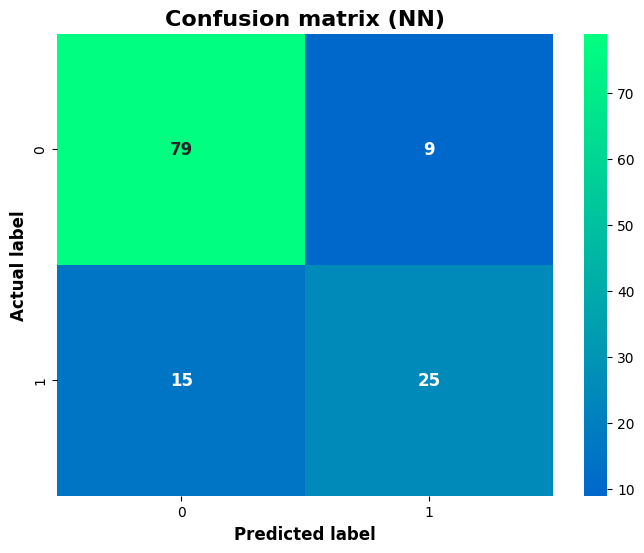

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        88
           1       0.74      0.62      0.68        40

    accuracy                           0.81       128
   macro avg       0.79      0.76      0.77       128
weighted avg       0.81      0.81      0.81       128



In [458]:
fig, ax = plt.subplots(figsize = (8, 6))
cm = confusion_matrix(y_true=actual_binary, y_pred=pred_binary)
sns.heatmap(
    data = cm, 
    cmap="winter", 
    center = 20, 
    annot=True, 
    annot_kws = {
        "fontsize":12, 
        "fontweight":"bold"
        },
    ax = ax
    )
plt.title(
    "Confusion matrix (NN)",
    fontsize = 16,
    fontweight = "bold"
    )
plt.xlabel(
    "Predicted label",
    fontsize = 12,
    fontweight = "bold"
    )
plt.ylabel(
    "Actual label",
    fontsize = 12,
    fontweight = "bold"
    )
fig.savefig("NeuralNetwork_ConfusionMatrix.png")
plt.show()

# Report
print(classification_report(actual_binary, pred_binary))

### Runtime

In [459]:
# Time end and total time
end = time.time()

# Total runtime
print(f'Total runtime: {end-start:.3f} s')

Total runtime: 32.196 s
